Restricted Boltzmann Machines
=============================

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import copy
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['axes.grid'] = False

if 'google.colab' in sys.modules and 'sklearn' not in sys.modules:
    !pip3 install scikit-learn

from keras.datasets import mnist
from sklearn.neural_network import BernoulliRBM

### Gibbs sampling
- is a Markov chain Monte Carlo (MCMC) technique for obtaining a sequence of samples from a multivariate probability distribution, especially when direct sampling is difficult. It is particularly useful in high-dimensional problems.

- The idea behind Gibbs sampling is to generate a sequence of samples that approximate the target multivariate distribution by sweeping through each variable (or block of variables) to sample from its conditional distribution with the other variables fixed to their current values.

- In the context of Restricted Boltzmann Machines (RBMs), Gibbs sampling is used to sample from the model's learned probability distribution. This is done by alternating between updating the hidden units and visible units, given the states of the other. This process is also known as Gibbs sampling in the RBM literature. The rbm_gibbs_sample_image function in your code is likely performing this sampling process on an image.

We consider some utility functions to be used later.

In [40]:
def rbm_gibbs_sample_image(rbm, im, steps):
  assert len(im.shape) < 3
  if len(im.shape) == 2:
    rows = im.shape[0]
    cols = im.shape[1]
    im = im.reshape((-1))
  else:
    im = im.copy()
  for _ in range(steps):
    im = rbm.gibbs(im)
    if len(im.shape) == 2:
      if rows is not None and cols is not None:
        im = im.reshape((rows, cols))
  return im.astype('float32')

def image_palette(X, nr = None, m = 20):
  if nr is None:
    nr = X.shape[0]
  return np.rollaxis(np.rollaxis(X[0:nr].reshape(m, -1, 28, 28), 0, 2), 1, 3).reshape(-1, m * 28)

def remove_rows(X, start, end):
  X = X.copy()
  if len(X.shape) == 2:
    X[start:end] = 0
  elif len(X.shape) == 3:
    X[:,start:end] = 0
  return X

Load the Dataset
----------------
Good ol' MNIST.

In [23]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
X_train = X_train.reshape((X_train.shape[0], -1))
X_test = X_test.reshape((X_test.shape[0],-1))
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
X_test = X_test[0:100]

(-0.5, 559.5, 139.5, -0.5)

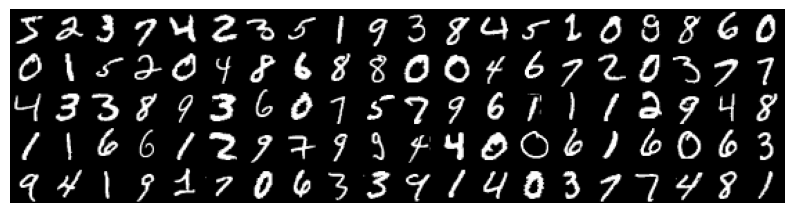

In [24]:
flattened_images = image_palette(X_train, 100)
plt.figure(figsize=(10,20))
plt.imshow(flattened_images)
plt.axis('off')

Train the RBM
-------------
**Exercise** What is the effect of the different parameters: **n_components**, **learning_rate**, **n_iter**. These parameters are, respectively, the number of components, the learning rate and the number of iterations. <br/>
Evaluate the performance visually in the next code cell.


In [63]:
rbm = BernoulliRBM(n_components=100, learning_rate=0.01, random_state=0, n_iter=30, verbose=True)
rbm.fit(X_train)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -112.24, time = 11.46s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -98.44, time = 9.53s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -92.52, time = 12.24s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -88.83, time = 11.69s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -85.67, time = 12.21s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -84.09, time = 11.73s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -82.24, time = 9.79s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -80.56, time = 11.63s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -80.00, time = 11.48s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -79.74, time = 11.77s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -78.45, time = 9.31s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -78.33, time = 11.86s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -78.41, time = 11.85s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -77.58, time = 11.37s
[BernoulliRBM] It

BernoulliRBM(learning_rate=0.01, n_components=100, n_iter=30, random_state=0,
             verbose=True)

Sample the Trained RBM and Show the Results
-------------------------------------------
The gibbs_steps variable determines how many Gibbs sampling steps will be performed for each test image i.e. with the test images as initialization. <br/>
**Exercise** Try different values and observe the result. Can you explain the result? <br/>
Compare the result with the original test images, shown one cell lower.


(-0.5, 559.5, 139.5, -0.5)

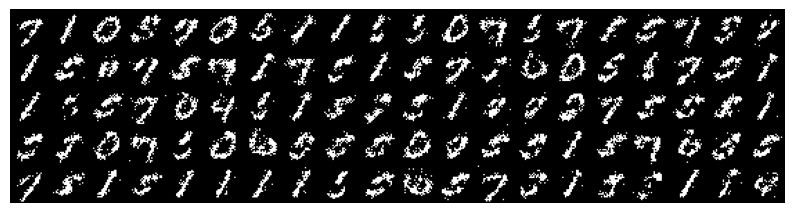

In [29]:
rbm2 = copy.deepcopy(rbm)
gibbs_steps = 200
a = X_test.copy()
for i in range(a.shape[0]):
  for j in range(gibbs_steps):
    a[i] = rbm2.gibbs(a[i])
plt.figure(figsize=(10,20))
plt.imshow(image_palette(a))
plt.axis('off')

(-0.5, 559.5, 139.5, -0.5)

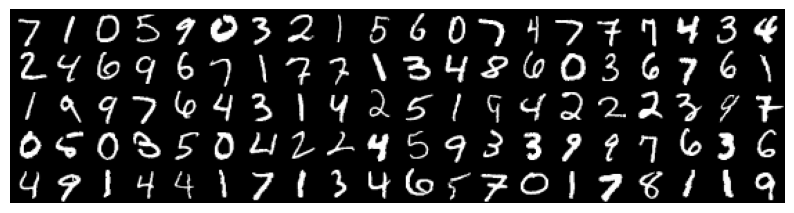

In [ ]:
plt.figure(figsize=(10,20))
plt.imshow(image_palette(X_test))
plt.axis('off')

## Reconstruction of Unseen Images
In this cell, we will remove pixel rows from certain images. Using the recently trained RBM, we will then try to reconstruct the original images.  <br/>
The following variables control this process: <br/>


*   **reconstruction_gibbs_steps**: The number of gibbs steps used to reconstruct the image.
*   **start_test_index**: The first index of the test set to use.
*   **nr**: the number of images starting from **start_test_index** to reconstruct.
*   **start_row_to_remove**:  The index of the first row that should be removed.
*   **end_row_to_remove**: The index up to which the rows should be removed.

**Exercise** Adjust these variables and observe the result of the reconstruction in the shown image.
What is the role of the previously seen RBM hyperparameters on the reconstruction? <br/>
How many rows can you remove such that reconstruction is still possible? <br/>
In the next code cell, the removed rows will be replaced by the reconstructed rows.




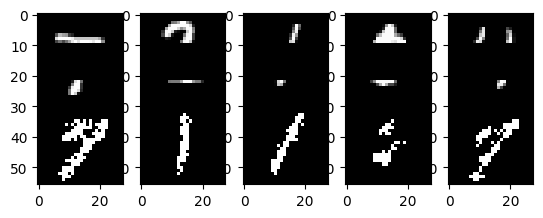

In [162]:
rbm3 = copy.deepcopy(rbm)
reconstruction_gibbs_steps = 49
start_test_index = 0
nr = 5
start_row_to_remove = 10
end_row_to_remove = 22

to_reconstruct = X_test[start_test_index:start_test_index + nr].reshape((-1,28,28))
to_reconstruct = remove_rows(to_reconstruct, start_row_to_remove, end_row_to_remove)
reconstructed = np.zeros(to_reconstruct.shape)
for i in range(nr):
  reconstructed[i] = rbm_gibbs_sample_image(rbm3, to_reconstruct[i], reconstruction_gibbs_steps).reshape((28,28))
combined_images = np.concatenate((to_reconstruct,reconstructed), axis=1)
fig = plt.figure()
for i in range(nr):
  ax1 = fig.add_subplot(1,nr,i+1)
  ax1.imshow(combined_images[i])

plt.show()

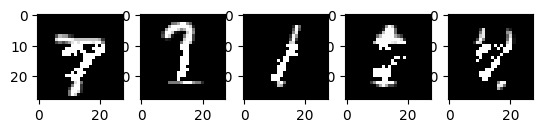

In [163]:
start_row_to_remove
end_row_to_remove
to_reconstruct[:,start_row_to_remove:end_row_to_remove] = reconstructed[:,start_row_to_remove:end_row_to_remove]
fig = plt.figure()
for i in range(nr):
  ax1 = fig.add_subplot(1,nr,i+1)
  ax1.imshow(to_reconstruct[i])

plt.show()

## Component Visualization
In the final cell, the components (weights of each neuron) of the RBM are shown.<br/>
Observing these components (think back to CNNs) may offer insights into the trained model.

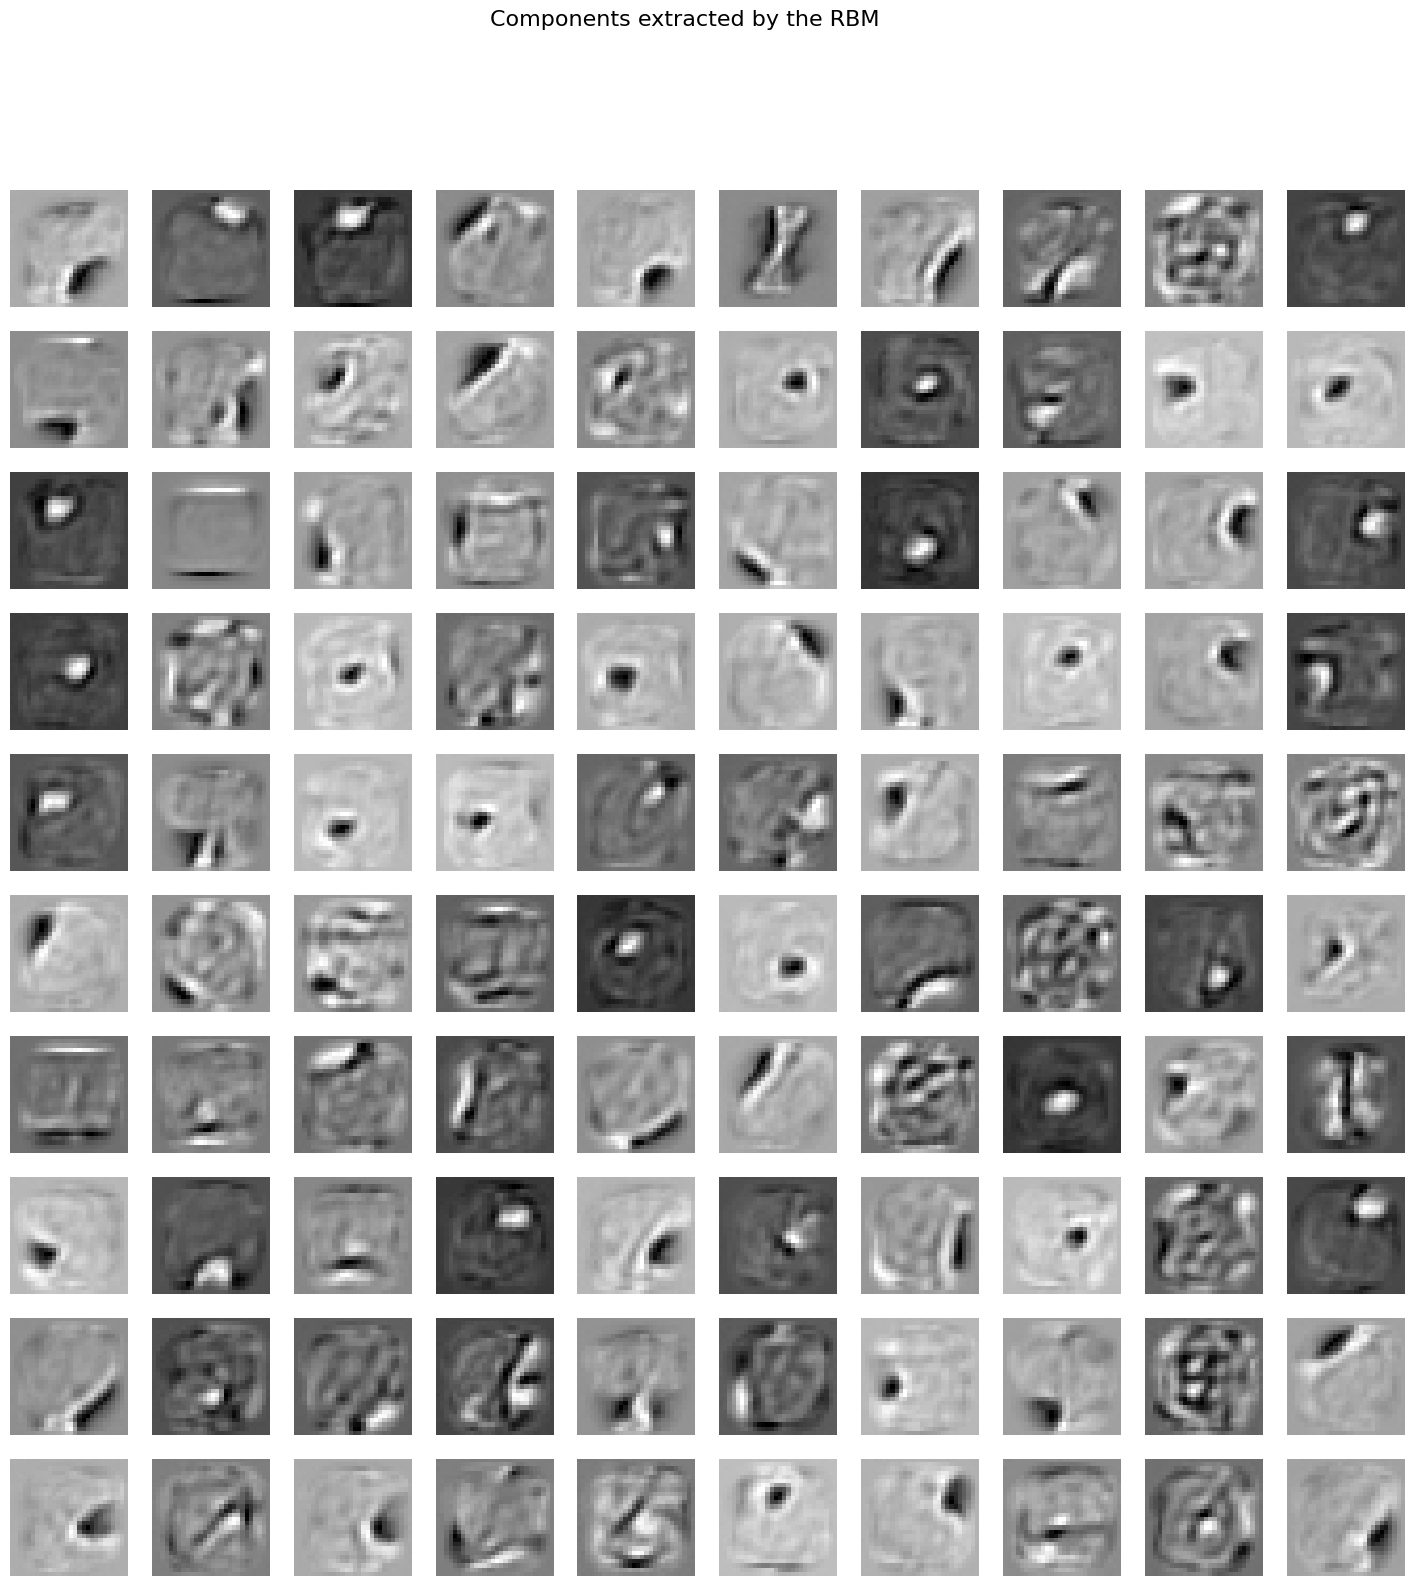

In [164]:
plt.figure(figsize=(18, 18))
nr_components = rbm.components_.shape[0]
for i in range(nr_components):
    c = rbm.components_[i]
    plt.subplot(10, int(np.ceil(nr_components/10)), i + 1)
    plt.imshow(c.reshape((28, 28)), cmap = "gray", interpolation='nearest')
    plt.axis('off')

plt.suptitle('Components extracted by the RBM', fontsize=16);